In [1]:
import warnings
warnings.filterwarnings('ignore') # For better visibility, warnings are turned off in this notebook

# Industrial Site

In this application of the FINE framework, an energy supply system, consisting of two-regions, is modeled and optimized.

The workflow is structures as follows:
-  Required packages are imported
-  An energy system model instance is created
-  Commodity sources are added to the energy supply system model
-  Commodity conversion components are added to the energy supply system model
-  Commodity storages are added to the energy supply system model
-  Commodity transmission components are added to the energy supply system model
-  Commodity sinks are added to the energy supply system model
-  The energy supply system model is optimized
-  Selected optimization results are presented

# Import required packages

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [2]:
import FINE as fn         # Provides objects and functions to model an energy system 
import pandas as pd       # Used to manage data in tables
import geopandas as gpd   # Used to display geo-referenced plots
import shapely as shp     # Used to generate geometric objects
import numpy as np        # Used to generate random input data

# Model an energy system

## Create an energy system model instance 

The structure of the energy supply system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_naturalGas_lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [3]:
# Input parameters
locations = {'industry_0'}
commodityUnitDict = {'electricity': r'MW$_{el}$', 'hydrogen': r'MW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen'}
numberOfTimeSteps, hoursPerTimeStep = 52560, 1/6 #8760, 1 
costUnit, lengthUnit = '1e3 Euro', 'km'

# Code
esM = fn.EnergySystemModel(locations=locations, commodities=commodities,
    numberOfTimeSteps=numberOfTimeSteps, commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=hoursPerTimeStep, costUnit=costUnit, lengthUnit=lengthUnit, verboseLogLevel=0)

## Add source component

Source components generate commodities across the energy system's virtual boundaries.

In [39]:
data = pd.read_excel('generationTimeSeries_e825103.xlsx')
data

,e825103_2017_2.3MW_faults9
0,0.573043
1,0.609130
2,0.623478
3,0.584783
4,0.646522
5,0.737391
6,0.681304
7,0.640000
8,0.558261
9,0.475217


In [41]:
operationRateMax = pd.DataFrame(data['e825103_2017_2.3MW_faults9'],index=range(numberOfTimeSteps)) # Dataset with least missing data
operationRateMax.columns = ['industry_0']

In [42]:
# Input parameters
name, commodity ='Wind turbines', 'electricity'
hasCapacityVariable = True
capacityFix = pd.Series([20], index=['industry_0']) # 10 MW_el = 0.01 GW_el
investPerCapacity, opexPerCapacity = 0, 30 # 30 €/kW = 30 1e6€/GW = 30 1e3€/MW
interestRate, economicLifetime = 0.08, 20

# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateMax=operationRateMax, capacityFix=capacityFix, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

In [43]:
operationRateMax.sum()

industry_0    12107.056522
dtype: float64

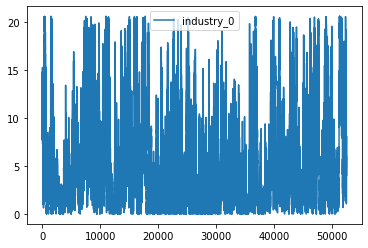

In [44]:
(capacityFix*operationRateMax).plot()

## Add conversion components

In [45]:
esM.add(fn.Conversion(esM=esM, name='PEMEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.67},
                      hasCapacityVariable=True, 
                      investPerCapacity=2300, opexPerCapacity=12.5, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=5))

In [46]:
esM.add(fn.Conversion(esM=esM, name='AEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.64},
                      hasCapacityVariable=True, 
                      investPerCapacity=1300, opexPerCapacity=18, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=9))

## Add storage components

In [47]:
esM.add(fn.Storage(esM=esM, name='Hydrogen tank (gaseous)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=1,
                   chargeRate=1, dischargeRate=1, sharedPotentialID=None,
                   stateOfChargeMin=0.06, stateOfChargeMax=1,
                   investPerCapacity=0.004, opexPerCapacity=0.004*0.02, interestRate=0.08,
                   economicLifetime=20))

### Industrial hydrogen demand

In [48]:
operationRateFix = pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']) # constant hydrogen demand of 2 MW_GH2: ATTN
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=operationRateFix))

In [49]:
operationRateFix.sum()/1e3

industry_0    17.52
dtype: float64

# Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [50]:
# Input parameters
numberOfTypicalPeriods=30
numberOfTimeStepsPerPeriod=24*6

# Code
esM.cluster(numberOfTypicalPeriods=numberOfTypicalPeriods,numberOfTimeStepsPerPeriod=numberOfTimeStepsPerPeriod)


Clustering time series data with 30 typical periods and 144 time steps per period...
		(0.9595 sec)



In [51]:
# Input parameters
timeSeriesAggregation=True
solver='gurobi'

# Code
esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

Time series aggregation specifications:
Number of typical periods:30, number of time steps per periods:144

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7237 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2187 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7743 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.4530 sec)

Declaring objective function...
		(0.1875 sec)

Academic license - for non-commercial use only
Read LP format model from file C:\Users\M8889~1.ZIE\AppData\Local\Temp\tmpk7iji36d.pyomo.lp
Reading time = 0.16 seconds
x30705: 48652 rows, 30705 columns, 119917 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Defaul

## Display optimization summaries

For each modeling class, an optimization summary can be stored and displayed. 

#### Source and Sink Component

In [31]:
srcSnkSummary = esM.getOptimizationSummary("SourceSinkModel", outputLevel=1)
display(esM.getOptimizationSummary("SourceSinkModel", outputLevel=2))

industry_0
Component       Property  Unit                             
Hydrogen demand operation [MW$_{H_{2},LHV}$*h/a]      17520
Wind turbines   TAC       [1e3 Euro/a]                  600
                capacity  [MW$_{el}$]                    20
                operation [MW$_{el}$*h/a]             27375
                opexCap   [1e3 Euro/a]                  600

#### Conversion Components

In [32]:
convSummary = esM.getOptimizationSummary("ConversionModel", outputLevel=1)
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))

industry_0
Component Property  Unit                      
AEC       TAC       [1e3 Euro/a]       1289.45
          capacity  [MW$_{el}$]        5.70293
          capexCap  [1e3 Euro/a]        1186.8
          invest    [1e3 Euro]         7413.81
          operation [MW$_{el}$*h/a]      27375
          opexCap   [1e3 Euro/a]       102.653

#### Storage Components

In [33]:
storSummary = esM.getOptimizationSummary("StorageModel", outputLevel=1)
display(esM.getOptimizationSummary("StorageModel", outputLevel=2))

industry_0
Component               Property           Unit                             
Hydrogen tank (gaseous) TAC                [1e3 Euro/a]             0.807064
                        capacity           [MW$_{H_{2},LHV}$*h]      1655.83
                        capexCap           [1e3 Euro/a]             0.674598
                        invest             [1e3 Euro]                6.62331
                        operationCharge    [MW$_{H_{2},LHV}$*h/a]    5500.45
                        operationDischarge [MW$_{H_{2},LHV}$*h/a]    5500.45
                        opexCap            [1e3 Euro/a]             0.132466

## Display regional and operational plots

Plots representing time series can be displayed for each component.

### Wind turbines

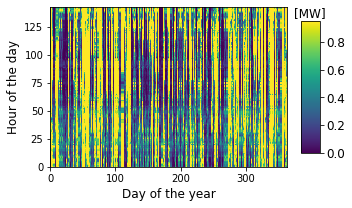

In [34]:
# If wind turbines are built in industry_0, their operation is displayed as heatmap
if srcSnkSummary.loc[('Wind turbines','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Wind turbines', 'industry_0', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='[MW]',nbTimeStepsPerPeriod=24*6)

### Electrolyzers 

In [35]:
# If PEMECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('PEMEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'PEMEC', 'industry_0', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='[MW]',nbTimeStepsPerPeriod=24*6)

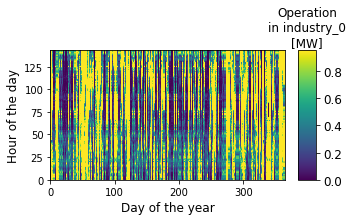

In [36]:
# If AECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('AEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'AEC', 'industry_0', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='Operation\nin industry_0\n[MW]',nbTimeStepsPerPeriod=24*6)

### Gaseous Hydrogen Tank

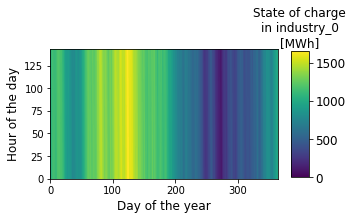

In [37]:
# If Gaseous Hydrogen Tanks are built in industry_0, their storage inventory is displayed as heatmap
if storSummary.loc[('Hydrogen tank (gaseous)','capacity','[MW$_{H_{2},LHV}$*h]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen tank (gaseous)', 'industry_0', figsize=(5,3),
        xlabel='Day of the year', ylabel='Hour of the day',
        zlabel='State of charge\nin industry_0\n[MWh]',
        variableName='stateOfChargeOperationVariablesOptimum',nbTimeStepsPerPeriod=24*6)

### Hydorgen Demand

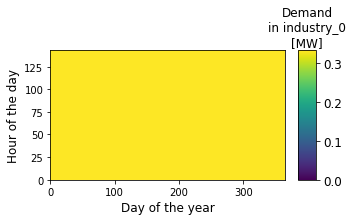

In [38]:
# The hydrogen demand time series in industry_0 is displayed
fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen demand', 'industry_0', figsize=(5,3), 
    xlabel='Day of the year', ylabel='Hour of the day', zlabel='Demand\nin industry_0\n[MW]',nbTimeStepsPerPeriod=24*6)